In [20]:
import numpy as np
from scipy import stats
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
def compute_confidence_interval(samples, conf_level=0.95):
    n_samples = len(samples)
    sample_mean = np.mean(samples)
    sample_std_dev = np.std(samples, ddof=1)
    
    # Calculate the margin of error
    margin_error = stats.t.ppf((1 + conf_level) / 2, n_samples - 1) * sample_std_dev / np.sqrt(n_samples)
    
    # Compute the confidence interval bounds
    conf_interval = (sample_mean - margin_error, sample_mean + margin_error)
    
    return sample_mean, conf_interval


# *Step 1: Estimate integral using crude Monte Carlo*

In [3]:
# Generate 100 random numbers uniformly distributed between 0 and 1
random_uniform_samples = np.random.uniform(0, 1, 100)
exp_values = np.exp(random_uniform_samples)

# Calculate and print the variance of the exponential values
variance_estimate_1 = np.var(exp_values)
print('Estimated variance: {:.4f}'.format(variance_estimate_1))

# Calculate the confidence interval using the new function
mean_estimate_1, (conf_lower, conf_upper) = compute_confidence_interval(exp_values)

# Output the results
print('Integral estimate: {:.4f}'.format(mean_estimate_1))
print('95% confidence interval: ({:.4f}, {:.4f})'.format(conf_lower, conf_upper))
print('Exact integral value: {:.4f}'.format(np.e - 1))

Estimated variance: 0.2049
Integral estimate: 1.7896
95% confidence interval: (1.6993, 1.8799)
Exact integral value: 1.7183


# *Step 2: Estimate integral using antithetic variables*

In [4]:
# Generate 100 random numbers uniformly distributed between 0 and 1
random_uniform_samples = np.random.uniform(0, 1, 100)
exp_values = np.exp(random_uniform_samples)

# Compute antithetic pairs and average
y = (exp_values + np.exp(1 - random_uniform_samples)) / 2

# Calculate and print the variance of the combined values
variance_estimate_2 = np.var(y)
print('Estimated variance: {:.4f}'.format(variance_estimate_2))

# Calculate the confidence interval using the antithetic variables
mean_estimate_2, (conf_lower, conf_upper) = compute_confidence_interval(y)

# Output the results
print('Integral estimate: {:.4f}'.format(mean_estimate_2))
print('95% confidence interval: ({:.4f}, {:.4f})'.format(conf_lower, conf_upper))
print('Exact integral value: {:.4f}'.format(np.e - 1))

Estimated variance: 0.0043
Integral estimate: 1.7182
95% confidence interval: (1.7051, 1.7313)
Exact integral value: 1.7183


# *Step 3: Estimate integral using control variates*

In [5]:
# Generate 100 random numbers uniformly distributed between 0 and 1
random_uniform_samples = np.random.uniform(0, 1, 100)
exp_values = np.exp(random_uniform_samples)

# Calculate the coefficient c using control variates
c = -np.cov(exp_values, random_uniform_samples)[0, 1] / np.var(random_uniform_samples)

# Adjust the values using the control variate
adjusted_values = exp_values + c * (random_uniform_samples - 0.5)

# Calculate and print the variance of the adjusted values
variance_estimate_3 = np.var(adjusted_values)
print('Estimated variance: {:.4f}'.format(variance_estimate_3))

# Calculate the confidence interval using the control variate adjusted values
mean_estimate_3, (conf_lower, conf_upper) = compute_confidence_interval(adjusted_values)

# Output the results
print('Integral estimate: {:.4f}'.format(mean_estimate_3))
print('95% confidence interval: ({:.4f}, {:.4f})'.format(conf_lower, conf_upper))
print('Exact integral value: {:.4f}'.format(np.e - 1))

Estimated variance: 0.0037
Integral estimate: 1.7195
95% confidence interval: (1.7073, 1.7317)
Exact integral value: 1.7183


# *Step 4: Estimate integral using stratified sampling*

In [6]:
# Perform stratified sampling
num_strata = 10
samples_per_stratum = 10
n = num_strata * samples_per_stratum

# Generate stratified samples and compute the exponential function
strata_means = []
for i in range(num_strata):
    us = np.random.uniform(0, 1, samples_per_stratum)
    stratum_samples = [np.exp((i + us[j]) / num_strata) for j in range(samples_per_stratum)]
    strata_means.append(np.mean(stratum_samples))

# Calculate and print the variance of the stratified sample means
variance_estimate_4 = np.var(strata_means)
print('Estimated variance: {:.4f}'.format(variance_estimate_4))

# Calculate the confidence interval using the stratified sample means
mean_estimate_4, (conf_lower, conf_upper) = compute_confidence_interval(strata_means)

# Output the results
print('Integral estimate: {:.4f}'.format(mean_estimate_4))
print('95% confidence interval: ({:.4f}, {:.4f})'.format(conf_lower, conf_upper))
print('Exact integral value: {:.4f}'.format(np.e - 1))

Estimated variance: 0.2360
Integral estimate: 1.7113
95% confidence interval: (1.3450, 2.0777)
Exact integral value: 1.7183


Below we can compare all of the estimated variances and mean estimates for all of the four methods

In [7]:
import pandas as pd

# Placeholder data for demonstration
data = {
    "Method": ["Crude Monte Carlo", "Antithetic Variables", "Control Variates", "Stratified Sampling"],
    "Mean Estimate": [mean_estimate_1, mean_estimate_2, mean_estimate_3, mean_estimate_4],
    "Variance Estimate": [variance_estimate_1, variance_estimate_2, variance_estimate_3, variance_estimate_4]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the table
print(df)

                 Method  Mean Estimate  Variance Estimate
0     Crude Monte Carlo       1.789626           0.204950
1  Antithetic Variables       1.718237           0.004315
2      Control Variates       1.719516           0.003736
3   Stratified Sampling       1.711322           0.236032


*Results speak for themself. Two methods with the lowest variance are Antithetic Variables and Control Variates. Two methods with the highest variance are Crude Monte Carlo and Stratified Sampling*

# *Step 5: Control variates for blocking queueing system simulation*

We start with initializing the parameters

In [8]:
num_servers = 10
avg_service_time = 8
avg_interarrival_time = 1
total_customers = 10000
simulation_count = 10

This function models the scenario as a Poisson process for customer arrivals coupled with exponential service durations. It outputs both the proportion of customers who couldn't be immediately served (blocked customers) and the average time between arrivals.

In [9]:
def queue_simulation(server_count, customer_count, service_time_avg, interarrival_time_avg):
    times_service_ends = np.zeros(server_count)
    current_time = 0
    total_blocked = 0
    total_arrival_time = 0
    
    for _ in range(customer_count):
        next_arrival = stats.expon.rvs(scale=interarrival_time_avg)
        total_arrival_time += next_arrival
        current_time += next_arrival
        next_service_end = times_service_ends.min()
        available_server = times_service_ends.argmin()

        if current_time < next_service_end:
            total_blocked += 1
        else:
            service_duration = stats.expon.rvs(scale=service_time_avg)
            times_service_ends[available_server] = current_time + service_duration

    return total_blocked / customer_count, total_arrival_time / customer_count


Then we perform ten simulations, saving for each one the fraction of blocked customers and the mean arrival time

In [10]:
blockage_rates = []
mean_arrivals = []
for _ in range(simulation_count):
    blockage, arrival = queue_simulation(num_servers, total_customers, avg_service_time, avg_interarrival_time)
    blockage_rates.append(blockage)
    mean_arrivals.append(arrival)


The control variates technique is employed to increase the accuracy of our estimates by reducing their variance. This method uses additional, correlated variables to adjust the estimates, thereby refining the precision of the results.

In [11]:
blockage_rates = np.array(blockage_rates)
mean_arrivals = np.array(mean_arrivals)

control_variable = -np.cov(blockage_rates, mean_arrivals)[0, 1] / mean_arrivals.var()
adjusted_blockage_rates = blockage_rates + control_variable * (mean_arrivals - avg_interarrival_time)

mean_blockage, (ci_lower, ci_upper) = compute_confidence_interval(blockage_rates)
adjusted_mean_blockage, (adjusted_ci_lower, adjusted_ci_upper) = compute_confidence_interval(adjusted_blockage_rates)

print(f'Original blockage rate estimate: {mean_blockage:.4f}')
print(f'Confidence interval: {ci_lower:.4f}, {ci_upper:.4f}\n')

print(f'Adjusted blockage rate estimate: {adjusted_mean_blockage:.4f}')
print(f'Confidence interval: {adjusted_ci_lower:.4f}, {adjusted_ci_upper:.4f}')

print(f'Variance of original estimates: {blockage_rates.var()}')
print(f'Variance of adjusted estimates: {adjusted_blockage_rates.var()}')


Original blockage rate estimate: 0.1227
Confidence interval: 0.1188, 0.1266

Adjusted blockage rate estimate: 0.1205
Confidence interval: 0.1173, 0.1238
Variance of original estimates: 2.6429599999999995e-05
Variance of adjusted estimates: 1.8620555778456776e-05


We can note that the variance has been reduced using control variates

# *Step 6: Common random numbers in queueing system simulation*

We start with initializing the parameters

In [12]:
num_servers = 10
avg_service_time = 8
avg_interarrival_time = 1
total_customers = 10000
simulation_count = 10

In [13]:
def simulate_queue_q2(nserver, customers, mean_st, mean_tbc, type='Exp', seed=0):
    np.random.seed(seed)
    if type == 'Exp':
        arrival_times = stats.expon(scale=1/mean_tbc).rvs(size=customers)
    elif type == 'Hyp':
        # Generate hyperexponential distribution
        p = 0.8
        rate1, rate2 = 0.8333, 5
        uniform_randoms = np.random.rand(customers)
        exp1 = stats.expon(scale=1/rate1).rvs(size=customers)
        exp2 = stats.expon(scale=1/rate2).rvs(size=customers)
        arrival_times = np.where(uniform_randoms < p, exp1, exp2)
    
    server_time = np.zeros(nserver)
    time = 0
    blocked = 0

    for i in range(customers):
        delta_arrival_time = arrival_times[i]
        time += delta_arrival_time
        min_server = np.min(server_time)
        idx_min_server = np.argmin(server_time)
        if time < min_server:
            blocked += 1
        else:
            server_time[idx_min_server] = time + stats.expon(scale=mean_st).rvs()

    return blocked / customers


We perform ten simulations of the two processes using ten different seeds, saving the blocked fraction of customers for each run. Then we perform a paired t-test to see if there is a difference between the two processes.

In [14]:
runs = []
for i in range(simulation_count):
    blocked_hyp = simulate_queue_q2(num_servers, total_customers, avg_service_time, avg_interarrival_time, 'Hyp', i)
    blocked_exp = simulate_queue_q2(num_servers, total_customers, avg_service_time, avg_interarrival_time, 'Exp', i)
    runs.append([blocked_hyp, blocked_exp])

runs = np.array(runs)
t_stat, p_value = stats.ttest_rel(runs[:, 0], runs[:, 1])
print(f"T-statistic: {t_stat}, P-value: {p_value}")
print(f'Estimated difference between the two processes: {np.mean(runs[:, 0] - runs[:, 1]):.4f}')

T-statistic: 3.3864360266556224, P-value: 0.008044434371616256
Estimated difference between the two processes: 0.0136


The p-value is very low, indicating a strong suggestion that the two processes perform differently. The estimation of the difference in performance is almost 2%, as printed above

### 7. Monte Carlo and importance sampling

We will try to estimate the probability of Z>a by generating 10 000 values from normal distribution and verifying how many of those values are greater than a. 

In [15]:
a = 4
num_of_samples = 10_000

samples = np.random.randn(num_of_samples)
samples = samples > a
mean = np.mean(samples)
true_value = 1 - stats.norm.cdf(a)

print('''
Estimated probability of Z>a: {:.8f}
The true value of Z>a probability: {:.8f}
'''.format(mean, true_value))


Estimated probability of Z>a: 0.00000000
The true value of Z>a probability: 0.00003167



When a=2 was used the estimation of the probability that Z>2 was more accurate since value a=2 lays reasonably near the mean of normal distribution, but with a=4 used the estimation was much worse. It is due to a=4 being much more extreme value so not many samples in those regions are generated. It is needed to significantly raise the number of samples drawn, to increase the accuracy of estimation. Now let's use importance sampling.

In [16]:
variance = 1
normal_samples = stats.norm.rvs(loc = a, scale = variance, size = num_of_samples)

target_density = stats.norm.pdf(normal_samples)
proposal_density = stats.norm.pdf(normal_samples, loc = a, scale = variance)
weights = target_density/proposal_density * (normal_samples > a)

mean = np.mean(weights)
true_value = 1 - stats.norm.cdf(a)

print('''
Estimated probability of Z>a: {:.8f}
The true value of Z>a probability: {:.8f}
'''.format(mean, true_value))


Estimated probability of Z>a: 0.00003114
The true value of Z>a probability: 0.00003167



Now we can see that the estimated proability is rather more accurate. Previously it was usually 0 or close to 0. Now its also very low since a=4 is an extreme value, but it doesn't equal 0 anymore.

### 8. Importance Sampling - exponential distribution and integral calculation

Let's first find the optimal value of lambda via analytical solution.

Optimal lambda: 1.3373737373737375


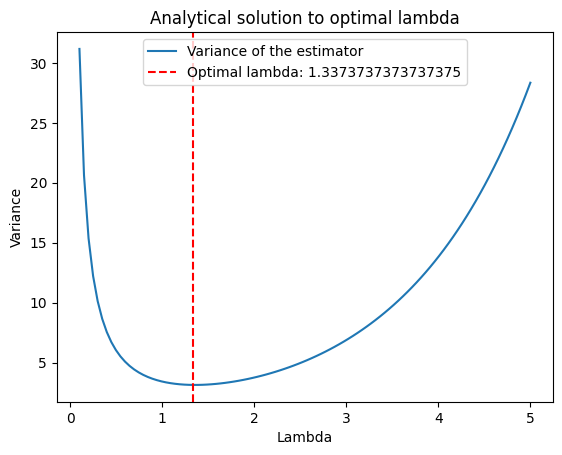

In [25]:
def f(x):
    return np.exp(x)

def g(x, lam):
    return lam * np.exp(-lam * x)

def h(x, lam):
    return f(x) / g(x, lam)

def variance(lam):
    expected_h = lambda x: h(x, lam) * g(x, lam)
    expected_h2 = lambda x: h(x, lam)**2 * g(x, lam)
    E_h, _ = quad(expected_h, 0, 1, args=())
    E_h2, _ = quad(expected_h2, 0, 1, args=())
    return E_h2 - E_h**2

lambdas = np.linspace(0.1, 5, 100)
variances = [variance(lam) for lam in lambdas]
optimal_lambda = lambdas[np.argmin(variances)]

print(f"Optimal lambda: {optimal_lambda}")

# Plot the variances
plt.plot(lambdas, variances, label='Variance of the estimator')
plt.axvline(optimal_lambda, color='r', linestyle='--', label=f'Optimal lambda: {optimal_lambda}')
plt.xlabel('Lambda')
plt.ylabel('Variance')
plt.title('Analytical solution to optimal lambda')
plt.legend()
plt.show()


Next we will calculate the estimation of the integral of exponential function from 0 to 1.

In [26]:
num_of_samples = 10_000

def estimate_integral(λ, sample_size):
    samples = stats.expon.rvs(scale=1/λ, size=sample_size)
    mask = (samples >= 0) & (samples <= 1)
    function_values = np.exp(samples)
    proposal_pdf = λ * np.exp(-λ * samples)
    weights = mask * function_values / proposal_pdf
    estimated_mean = np.mean(weights)
    variance = np.var(weights, ddof=1)
    return estimated_mean, variance

best_mean, best_variance = estimate_integral(optimal_lambda, num_of_samples)

print('''
Lambda used: {:.8f}
      
Estimated value of the integral: {:.8f}
Estimated variance: {:.8f}
The true value of the integral: {:.8f}
'''.format(optimal_lambda, best_mean, best_variance, np.e - 1))


Lambda used: 1.33737374
      
Estimated value of the integral: 1.69941265
Estimated variance: 3.03325863
The true value of the integral: 1.71828183



Closeness to True Value: The estimated value of the integral is relatively close to the true value, suggesting that the importance sampling method is effective, but the accuracy could potentially be improved.

High Variance: The relatively high variance in the estimation suggests that the exponential sampling distribution might not be perfectly aligned with the integral. This misalignment could be causing inefficient sampling, leading to a higher variance in the estimate.

### 9. Pareto: IS estimator using the first moment distribution

We have estimated a mean of Pareto distribution using importance sampling with First Moment Pareto Distribution as sampling distribution which is a Pareto distribution with "k" parameter decreased by 1.

In [27]:
k = 1.025
pareto_samples = stats.pareto.rvs(k - 1, size=num_of_samples)

target_density = stats.pareto.pdf(pareto_samples, k)
proposal_density = stats.pareto.pdf(pareto_samples, k - 1)

importance_weights = pareto_samples * (target_density / proposal_density)

estimated_mean, confidence_bounds = compute_confidence_interval(importance_weights)
true_mean = k / (k - 1)
sample_variance = np.var(importance_weights, ddof=1)

print(f'''
Calculated mean estimate: {estimated_mean}
Confidence interval: lower: {confidence_bounds[0]}, upper: {confidence_bounds[1]}
True mean value: {true_mean}
Variance value: {sample_variance}
''')


Calculated mean estimate: 40.991800000000126
Confidence interval: lower: 40.980434781191356, upper: 41.003165218808896
True mean value: 41.00000000000014
Variance value: 0.33616637663766585



Although we can see that we have achieved very precise estimationm this solution is not meaningful, because using the first moment distribution could lead to increased variance in the IS estimator. The key to effective importance sampling is choosing g(x) that closely matches the shape of f(x). The first moment distribution does not achieve this. Also the first moment distribution is not directly related to the target distribution in a way that simplifies the computation.

To find the first moment distribution, we should consider the mean of the target distribution and attempt to construct a new distribution that has this mean.

A more practical approach in importance sampling is to choose g(x) based on:

- Heuristic Methods: Using known properties of f(x) and h(x) to choose a similar distribution g(x).

- Optimization: Minimizing the variance of the IS estimator by solving an optimization problem to find the best g(x).